## A Crash Course on Data Analysis using "Scientific" Python
### Based on Chapter 1 of Wes McKinney's book, "Python for Data Analysis"
--------------------------------------------
Python for Data Analysis  
by Wes McKinney  
Copyright © 2013 Wes McKinney. All rights reserved.  
Printed in the United States of America.  
Published by O’Reilly Media, Inc., 1005 Gravenstein Highway North, Sebastopol, CA 95472  

----------------------------------------------

In the first chapter of Wes's book, he works through three high-level scenarios of what are typical Data Analysis strategies. I worked through the narrative and code examples and created the following **Jupyter notebook**. It dawned on me this could be useful for others who are familiar with analysis techniques, but just not using Python. 

It's also possible some of this might make your brain hurt (it made mine hurt). That's why you have this notebook. Run the cells, change stuff, break stuff... The beauty of Jupyter notebooks is that they are *alive*--like a living, breathing book that you can change and alter. Have fun with it!

It's my hope that this might save some folks time and angst getting up to speed on scientific Python.

*Dave Kinney - October 2019*  

In [1]:
# Import all the libraries we'll need...
import json
import numpy as np
import pandas as pd

from pandas import DataFrame, Series

### usa.gov data from bit.ly  
Suppose we are interesting in the most often-occuring time zones in the US government feed of anaonymous users data.

In [2]:
# Read one line of data from the USA Gov file
path = '../datasets/bitly_usagov/example.txt'
open(path).readline()

'{ "a": "Mozilla\\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\\/535.11 (KHTML, like Gecko) Chrome\\/17.0.963.78 Safari\\/535.11", "c": "US", "nk": 1, "tz": "America\\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\\/\\/www.facebook.com\\/l\\/7AQEFzjSi\\/1.usa.gov\\/wfLQtf", "u": "http:\\/\\/www.ncbi.nlm.nih.gov\\/pubmed\\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }\n'

In [3]:
# Convert to JSON records
records = [json.loads(line) for line in open(path)]
records[0]
records[0]['tz']

'America/New_York'

In [4]:
# Using a list comprehension to use only those records that actually have a 'tz' value
time_zones = [rec['tz'] for rec in records if 'tz' in rec]
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

In [5]:
# Convert the JSON to a pandas dataframe
frame = DataFrame(records)
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

In [6]:
# Clean the data by replacing NA's with 'Missing' and nulls with 'Unknown'
tz_counts = frame['tz'].value_counts()
clean_tz = frame['tz'].fillna('Missing')
clean_tz[clean_tz == ''] = "Unknown"
tz_counts = clean_tz.value_counts()
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

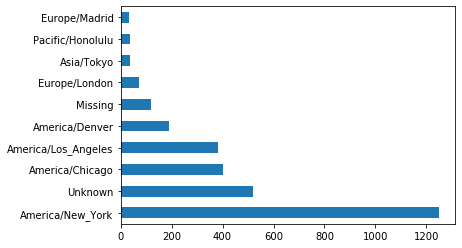

In [7]:
%matplotlib inline
tz_counts[:10].plot(kind='barh', rot=0)

Now, suppose you wanted to decompose the top time zones into Windows and non-Windows users. As a simplification, let’s say that a user is on Windows if the string 'Windows' is in the agent string. Since some of the agents are missing, I’ll exclude these from the data. We want to then compute a value whether each row is Windows or not.

In [8]:
cframe = frame[frame.a.notnull()] # Exclude missing data
operating_system = np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')
by_tz_os = cframe.groupby(['tz', operating_system])
agg_counts = by_tz_os.size().unstack().fillna(0)
agg_counts[:10]

,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


In [9]:
# Use to sort in ascending order
indexer = agg_counts.sum(1).argsort()
indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

In [10]:
# slice off the last 10 rows
count_subset = agg_counts.take(indexer)[-10:]
count_subset

,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


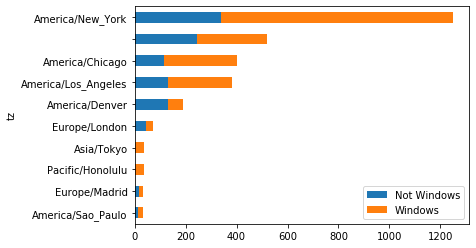

In [11]:
count_subset.plot(kind='barh', stacked=True)

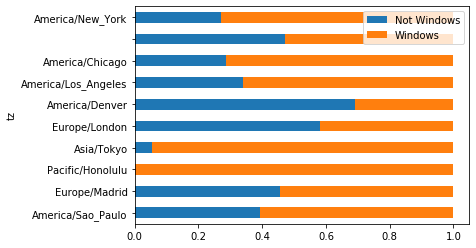

In [12]:
normed_subset = count_subset.div(count_subset.sum(1), axis=0)
normed_subset.plot(kind='barh', stacked=True)

*************************
### MovieLens 1M Data Set

In [13]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_csv('../datasets/movielens/users.dat', sep='::', header=None, names=unames, engine='python')
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../datasets/movielens/ratings.dat', sep='::', header=None, names=rnames, engine='python')
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_csv('../datasets/movielens/movies.dat', sep='::', header=None, names=mnames, engine='python')

Suppose you wanted to compute mean ratings for a particular movie by sex and age. This is much easier to do with all of the data merged together into a single table. Using pandas’s merge function, we first merge ratings with
users then merging that result with the movies data. **pandas infers which columns to use as the merge (or join) keys based on overlapping names.**

In [14]:
data = pd.merge(pd.merge(ratings, users), movies)

In [15]:
data

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,M,18,17,47901,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,M,35,14,30030,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,M,18,17,92886,White Boys (1999),Drama
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Comedy|Drama|Western


In this form, aggregating the ratings grouped by one or more user or movie attributes is straightforward once you build some familiarity with pandas. To get mean movie ratings for each film grouped by gender, we can use the **pivot_table** method. This produces another DataFrame containing mean ratings with movie totals as row (index) labels and gender as column labels.

In [16]:
mean_ratings = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [17]:
# group the data by title and use size() to get a Series of group sizes for each title
ratings_by_title = data.groupby('title').size()
ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [18]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [19]:
# The index of titles receiving at least 250 ratings can then be used to select rows from mean_ratings above.
mean_ratings = mean_ratings.loc[active_titles]
mean_ratings

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
...,...,...
Young Guns (1988),3.371795,3.425620
Young Guns II (1990),2.934783,2.904025
Young Sherlock Holmes (1985),3.514706,3.363344


In [20]:
# To see the top films among female viewers, we can sort by the F column in descending order.
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)
top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


Suppose you wanted to find the movies that are most divisive between male and female viewers. One way is to add a column to mean_ratings containing the difference in means, then sort by that.

In [21]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']
sorted_by_diff = mean_ratings.sort_values(by='diff')
sorted_by_diff[:15]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


Reversing the order of the rows and again slicing off the top 15 rows, we get the movies preferred by men that women didn’t rate as highly.

In [22]:
# Reverse order of rows, take first 15 rows
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


Suppose instead you wanted the movies that elicited the most disagreement among viewers, independent of gender. Disagreement can be measured by the variance or standard deviation of the ratings.

In [23]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()

# Filter down to active_titles
rating_std_by_title = rating_std_by_title.loc[active_titles]

# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

--------------------------------
### US Baby Names 1880-2019

There are many things you might want to do with the data set:

* Visualize the proportion of babies given a particular name (your own, or another name) over time.
* Determine the relative rank of a name.
* Determine the most popular names in each year or the names with largest increases or decreases.
* Analyze trends in names: vowels, consonants, length, overall diversity, changes in spelling, first and last letters.
* Analyze external sources of trends: biblical names, celebrities, demographic changes

In [24]:
names1880 = pd.read_csv('../datasets/babynames/yob1880.txt', names=['name', 'sex', 'births'])
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [25]:
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [26]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

Since the data set is split into files by year, one of the first things to do is to assemble all of the data into a single DataFrame and further to add a year field. This is easy to do using **pandas.concat**.

In [27]:
# 2010 is the last available year right now
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = '../datasets/babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    frame['year'] = year
    pieces.append(frame)
    
# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

With this data in hand, we can already start aggregating the data at the year and sex level using groupby or pivot_table.

In [28]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


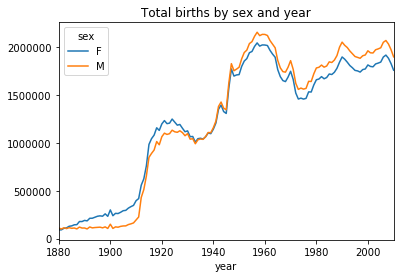

In [29]:
total_births.plot(title='Total births by sex and year')

Next, let’s insert a column prop with the fraction of babies given each name relative to the total number of births. A prop value of 0.02 would indicate that 2 out of every 100 babies was given a particular name. Thus, we group the data by year and sex, then add the new column to each group.

In [30]:
def add_prop(group):
    # Integer division floors
    births = group.births.astype(float)
    group['prop'] = births / births.sum()
    return group
    
names = names.groupby(['year', 'sex']).apply(add_prop)
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


When performing a group operation like this, it's often valuable to do a sanity check, like verifying that the *prop* column sums to 1 within all the groups. Since this is floating point data, use **np.allclose** to check that the group sums are sufficiently close to (but perhaps not exactly equal to) 1.

In [31]:
np.allclose(names.groupby(['year', 'sex']).prop.sum(), 1)

True

In [32]:
# Extract a subset of the data to facilitate further analysis: 
# the top 1000 names for each sex/year combination.
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
    
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)

# Need to rename the column "year" to avoid later conflicts with the index "year"
# Same for 'sex', which I'll change to 'gender' for the column label
top1000.rename(columns={'year': 'byear'}, inplace=True)
top1000.rename(columns={'sex': 'gender'}, inplace=True)

top1000

name gender  births  byear      prop
year sex                                                   
1880 F   0             Mary      F    7065   1880  0.077643
         1             Anna      F    2604   1880  0.028618
         2             Emma      F    2003   1880  0.022013
         3        Elizabeth      F    1939   1880  0.021309
         4           Minnie      F    1746   1880  0.019188
...                     ...    ...     ...    ...       ...
2010 M   1677639     Camilo      M     194   2010  0.000102
         1677640     Destin      M     194   2010  0.000102
         1677641     Jaquan      M     194   2010  0.000102
         1677642     Jaydan      M     194   2010  0.000102
         1677645     Maxton      M     193   2010  0.000102

[261877 rows x 5 columns]

In [33]:
type(top1000)

pandas.core.frame.DataFrame

### Analyzing Naming Trends
With the full data set and Top 1,000 data set in hand, we can start analyzing various naming trends of interest. Splitting the Top 1,000 names into the boy and girl portions is easy to do first.

In [34]:
boys = top1000[top1000.gender == 'M']
girls = top1000[top1000.gender == 'F']

Simple time series, like the number of Johns or Marys for each year can be plotted but require a bit of munging to be a bit more useful. Let’s form a pivot table of the total number of births by year and name.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010BD9248>,
      dtype=object)

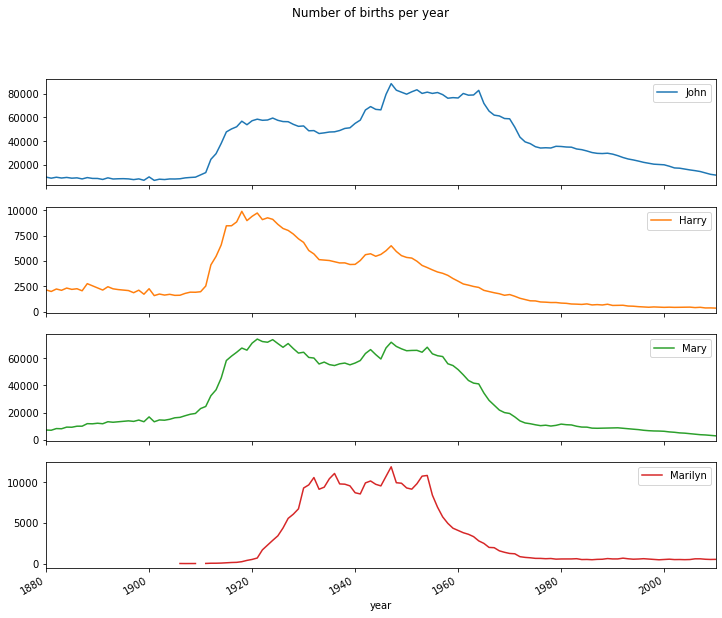

In [35]:
total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)

# Now, this can be plotted for a handful of names using DataFrame’s plot method:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12, 10), grid=False, title="Number of births per year")

### Measuring the increase in naming diversity
One explanation for the decrease in plots above is that fewer parents are choosing common names for their children. This **hypothesis** can be explored and confirmed in the data. One measure is the proportion of births represented by the top 1000 most popular names, which I aggregate and plot by year and sex

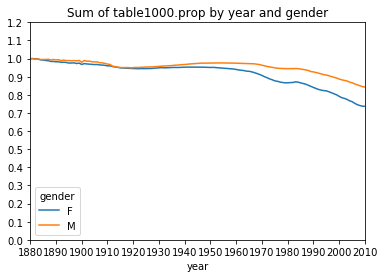

In [36]:
table = top1000.pivot_table('prop', index='year', columns='gender', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and gender', 
            yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

So you can see that, indeed, there appears to be increasing name diversity (decreasing total proportion in the top 1,000). Another interesting metric is the number of distinct names, taken in order of popularity from highest to lowest, in the top 50% of births. This number is a bit more tricky to compute. Let’s consider just the boy names from 2010.

In [37]:
df = boys[boys.byear == 2010]
df

name gender  births  byear      prop
year sex                                                 
2010 M   1676644    Jacob      M   21875   2010  0.011523
         1676645    Ethan      M   17866   2010  0.009411
         1676646  Michael      M   17133   2010  0.009025
         1676647   Jayden      M   17030   2010  0.008971
         1676648  William      M   16870   2010  0.008887
...                   ...    ...     ...    ...       ...
         1677639   Camilo      M     194   2010  0.000102
         1677640   Destin      M     194   2010  0.000102
         1677641   Jaquan      M     194   2010  0.000102
         1677642   Jaydan      M     194   2010  0.000102
         1677645   Maxton      M     193   2010  0.000102

[1000 rows x 5 columns]

After sorting prop in descending order, we want to know how many of the most popular names it takes to reach 50%. You could write a for loop to do this, but a vectorized NumPy way is a bit more clever. Taking the cumulative sum, cumsum, of prop then calling the method searchsorted returns the position in the cumulative sum at which 0.5 would need to be inserted to keep it in sorted order.

In [38]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum[:10]

year  sex         
2010  M    1676644    0.011523
           1676645    0.020934
           1676646    0.029959
           1676647    0.038930
           1676648    0.047817
           1676649    0.056579
           1676650    0.065155
           1676651    0.073414
           1676652    0.081528
           1676653    0.089621
Name: prop, dtype: float64

In [39]:
# Remember that Python arrays start at 0, so we have to add 1 to the result.
prop_cumsum.searchsorted(0.5) + 1

117

In [40]:
# Do the same calculations for the year 1900
df = boys[boys.byear == 1900]
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()
in1900.searchsorted(0.5) + 1

25

It should now be fairly straightforward to apply this operation to each year/sex combination; **groupby** those fields and apply a function returning the count for each group.

In [41]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1
    
diversity = top1000.groupby(['byear', 'gender']).apply(get_quantile_count)
diversity = diversity.unstack('gender')

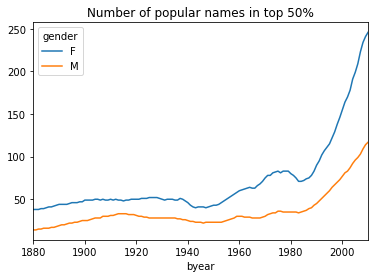

In [42]:
diversity.plot(title="Number of popular names in top 50%")

**Conclusion** - girl names have always been more diverse than boy names, and they have only become more so over time.